In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../modules')
from FSC import GenerationDiscreteObs as FSC_DiscreteObs
from FSC import InferenceDiscreteObs as FSC_InferenceDiscreteObs
import ObsModels 

In [3]:
# set matplotlib font to avenir
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'

# Finite State Controller with $M = 2$, $A = 2$, $Y = 2$

# Observations

In [68]:
NStepsObs = 100
NTraj = 100
Y = 2
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 2*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 0)
observations.shape

(100, 100)

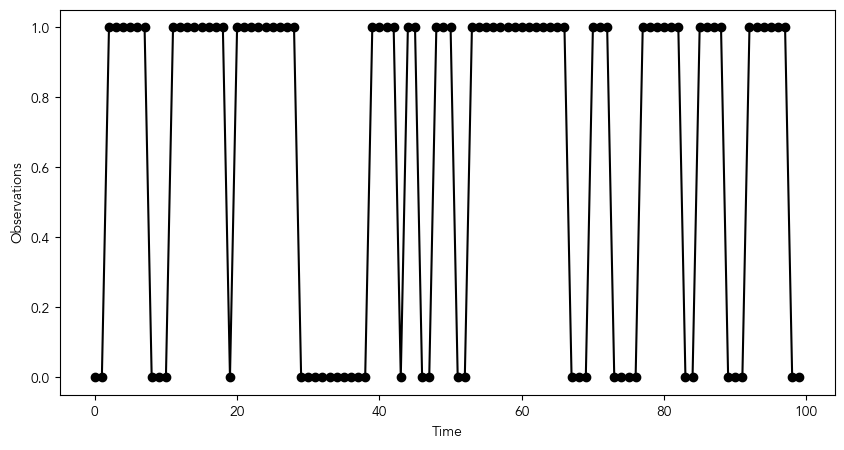

In [69]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(observations[0], 'o', label='Trajectory 0', color='black')
plt.plot(observations[0], color='black', label='Trajectory 0')
ax.set_xlabel('Time')
ax.set_ylabel('Observations')

plt.show()

## Structured transition matrix

In [70]:
M = 2
A = 2

ThetaFollowSwitch = np.array([[[[10, 0.01], [0.01, 0.01]],
                               [[0.01, 0.01], [0.01, 10]]],
                              [[[0.01, 0.01], [0.01, 10]],
                               [[10, 0.01], [0.01, 0.01]]]])


Psi = np.array([1, 2])

FSC = FSC_DiscreteObs(ThetaFollowSwitch, Psi, verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 2 observations.


In [71]:
FSC.load_observations(observations[:100])

In [72]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

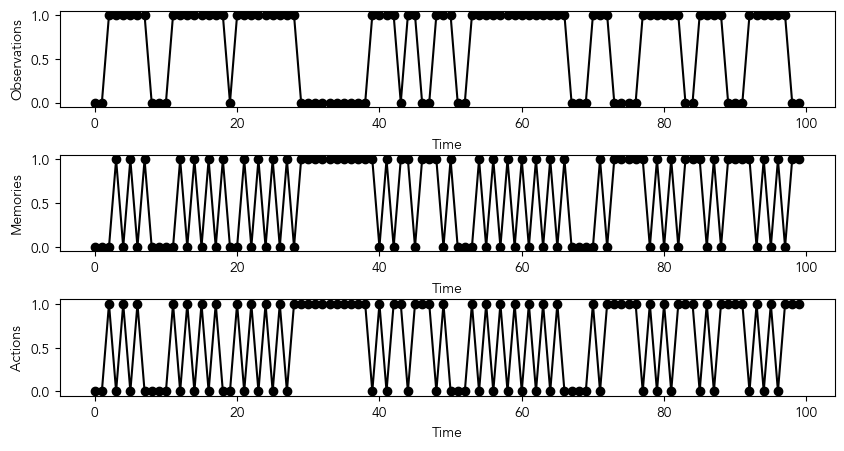

In [73]:
idx_trj = 0
trj = trajectories[idx_trj]
fig, ax = FSC.plot_trajectory(trj, Time)

In [74]:
FSC.evaluate_nloglikelihood(trajectories[0])

1.3268468898572643

### Inference

In [75]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123)
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(74.0828, device='mps:0', grad_fn=<SubBackward0>)

In [76]:
tloss, vloss = FSC_tofit.optimize(NEpochs = 10, NBatch = 20, lr = 0.2, gamma = 0.9)

Training with 80 trajectories and validating with 20 trajectories.
Epoch 1 - Training loss: 61.97389373779296, Validation loss: 53.61533870697021 - Learning rate: 0.18000000000000002
Epoch 2 - Training loss: 46.231770324707036, Validation loss: 39.08866672515869 - Learning rate: 0.16200000000000003
Epoch 3 - Training loss: 27.828944396972656, Validation loss: 20.184197187423706 - Learning rate: 0.14580000000000004
Epoch 4 - Training loss: 12.186783790588379, Validation loss: 8.375284600257874 - Learning rate: 0.13122000000000003
Epoch 5 - Training loss: 5.226679420471191, Validation loss: 4.060385668277741 - Learning rate: 0.11809800000000004
Epoch 6 - Training loss: 2.8179086208343502, Validation loss: 2.56951590180397 - Learning rate: 0.10628820000000004
Epoch 7 - Training loss: 1.9233070850372318, Validation loss: 1.9779599905014038 - Learning rate: 0.09565938000000004
Epoch 8 - Training loss: 1.5236290454864503, Validation loss: 1.7051721960306168 - Learning rate: 0.086093442000000

### Comparison

In [77]:
FSC_inferred = FSC_DiscreteObs(FSC_tofit.theta.detach().cpu().double().numpy(),
                               FSC_tofit.psi.detach().cpu().double().numpy(), verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 2 observations.


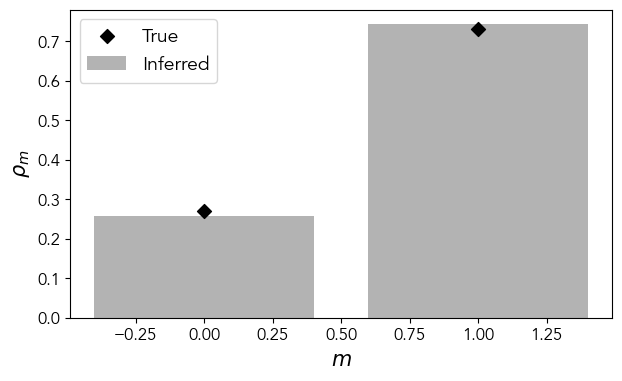

In [78]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(np.arange(M), FSC_inferred.rho, color = "dimgray", alpha = 0.5, label = "Inferred")
ax.scatter(np.arange(M), FSC.rho, color = "black", marker = "D", s = 50, label = "True")

ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.legend(fontsize = 14)

plt.show()

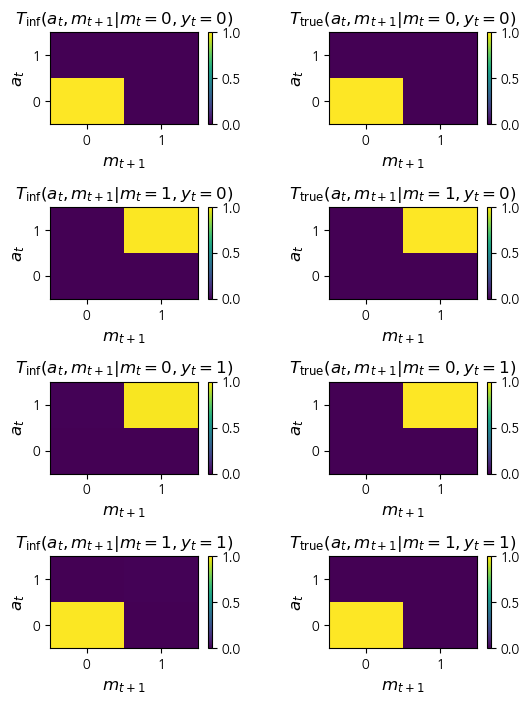

In [79]:
fig, axs = plt.subplots(Y*M, 2, figsize=(6,8))
plt.subplots_adjust(hspace = 0.9, wspace=0.5)
for a in axs.flatten():
    a.set_xticks(FSC.MemSpace)
    a.set_yticks(FSC.ActSpace)
    a.set_xlabel("$m_{t+1}$", fontsize = 12)
    a.set_ylabel("$a_t$", fontsize = 12)

c = 0
for idx_y, y in enumerate(FSC_inferred.ObsSpace):
    for idx_m, m in enumerate(FSC_inferred.MemSpace):
        im_inf = axs[c, 0].pcolormesh(FSC_inferred.MemSpace, FSC_inferred.ActSpace, FSC_inferred.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)
        im_true = axs[c, 1].pcolormesh(FSC.MemSpace, FSC.ActSpace, FSC.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)

        axs[c, 0].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")
        axs[c, 1].set_title(f"$T_\\mathrm{{true}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")

        cbar_inf = fig.colorbar(im_inf, ax=axs[c, 0])
        cbar_true = fig.colorbar(im_true, ax=axs[c, 1])

        c += 1

plt.show()

In [80]:
FSC_inferred.load_observations(observations)

In [81]:
trajectories_inferred = FSC_inferred.generate_trajectories(NSteps)

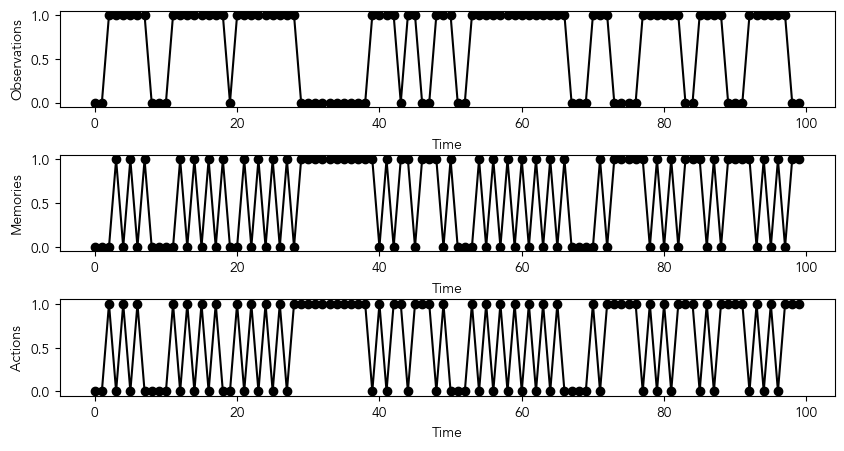

In [82]:
idx_trj = 0
trj = trajectories_inferred[idx_trj]
fig, ax = FSC_inferred.plot_trajectory(trj, Time)

# $M = 2$, $A = 2$, $Y = 2$, random

In [ ]:
M = 2
A = 2

np.random.seed(7)

Theta = np.random.randn(Y, M, M, A)

Psi = np.random.randn(M)

FSC = FSC_DiscreteObs(Theta, Psi, verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 2 observations.


In [84]:
FSC.load_observations(observations)

In [85]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

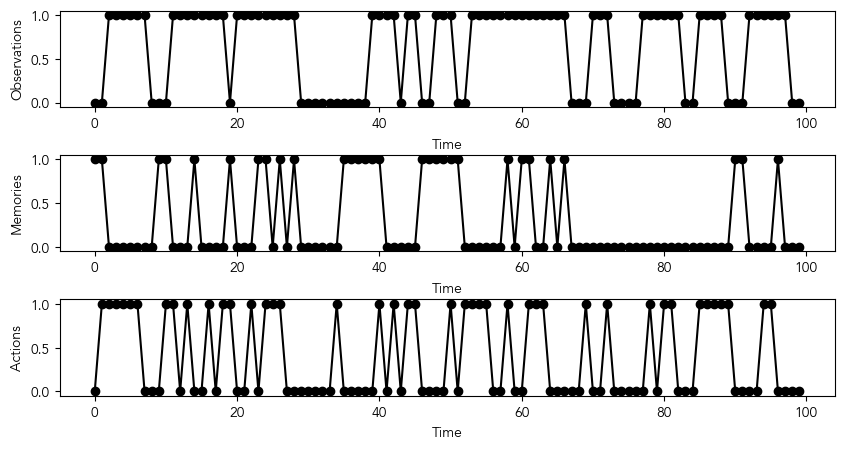

In [86]:
idx_trj = 0
trj = trajectories[idx_trj]
fig, ax = FSC.plot_trajectory(trj, Time)

In [87]:
FSC.evaluate_nloglikelihood(trajectories[0])

65.76301573204904

### Inference

In [93]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123456789)
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(67.8492, device='mps:0', grad_fn=<SubBackward0>)

In [94]:
tloss, vloss = FSC_tofit.optimize(NEpochs = 10, NBatch = 20, lr = 0.1, gamma = 0.9)

Training with 80 trajectories and validating with 20 trajectories.
Epoch 1 - Training loss: 69.199560546875, Validation loss: 67.46923503875732 - Learning rate: 0.09000000000000001
Epoch 2 - Training loss: 65.904931640625, Validation loss: 66.55188064575195 - Learning rate: 0.08100000000000002
Epoch 3 - Training loss: 66.2189193725586, Validation loss: 66.83796997070313 - Learning rate: 0.07290000000000002
Epoch 4 - Training loss: 66.13954010009766, Validation loss: 66.41312942504882 - Learning rate: 0.06561000000000002
Epoch 5 - Training loss: 65.63160858154296, Validation loss: 66.08476638793945 - Learning rate: 0.05904900000000002
Epoch 6 - Training loss: 65.4876937866211, Validation loss: 66.07539768218994 - Learning rate: 0.05314410000000002
Epoch 7 - Training loss: 65.50611419677735, Validation loss: 66.02543048858642 - Learning rate: 0.04782969000000002
Epoch 8 - Training loss: 65.52330474853515, Validation loss: 65.96214122772217 - Learning rate: 0.043046721000000024
Epoch 9 - 

### Comparison

In [95]:
FSC_inferred = FSC_DiscreteObs(FSC_tofit.theta.detach().cpu().double().numpy(),
                               FSC_tofit.psi.detach().cpu().double().numpy(), verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 2 observations.


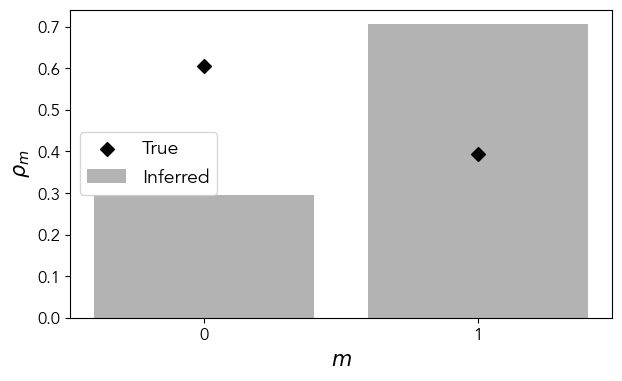

In [96]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(np.arange(M), FSC_inferred.rho, color = "dimgray", alpha = 0.5, label = "Inferred")
ax.scatter(np.arange(M), FSC.rho, color = "black", marker = "D", s = 50, label = "True")

ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xticks(np.arange(M))

plt.legend(fontsize = 14)

plt.show()

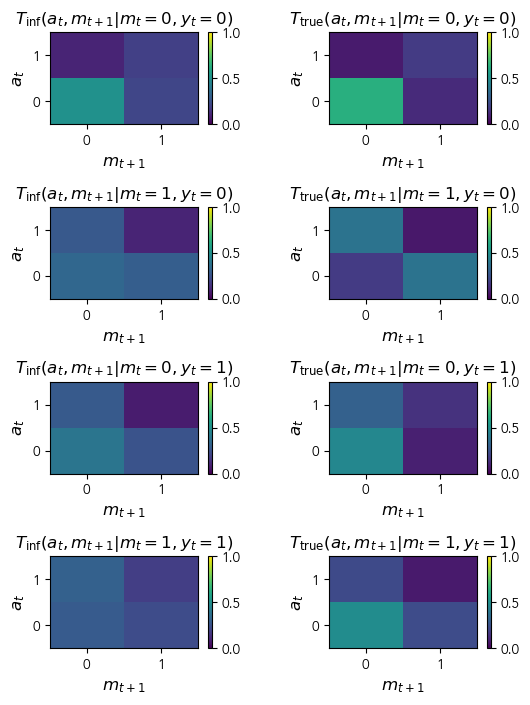

In [97]:
fig, axs = plt.subplots(Y*M, 2, figsize=(6,8))
plt.subplots_adjust(hspace = 0.9, wspace=0.5)
for a in axs.flatten():
    a.set_xticks(FSC.MemSpace)
    a.set_yticks(FSC.ActSpace)
    a.set_xlabel("$m_{t+1}$", fontsize = 12)
    a.set_ylabel("$a_t$", fontsize = 12)

c = 0
for idx_y, y in enumerate(FSC_inferred.ObsSpace):
    for idx_m, m in enumerate(FSC_inferred.MemSpace):
        im_inf = axs[c, 0].pcolormesh(FSC_inferred.MemSpace, FSC_inferred.ActSpace, FSC_inferred.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)
        im_true = axs[c, 1].pcolormesh(FSC.MemSpace, FSC.ActSpace, FSC.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)

        axs[c, 0].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")
        axs[c, 1].set_title(f"$T_\\mathrm{{true}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")

        cbar_inf = fig.colorbar(im_inf, ax=axs[c, 0])
        cbar_true = fig.colorbar(im_true, ax=axs[c, 1])

        c += 1

plt.show()

In [98]:
FSC_inferred.load_observations(observations)

In [99]:
trajectories_inferred = FSC_inferred.generate_trajectories(NSteps)

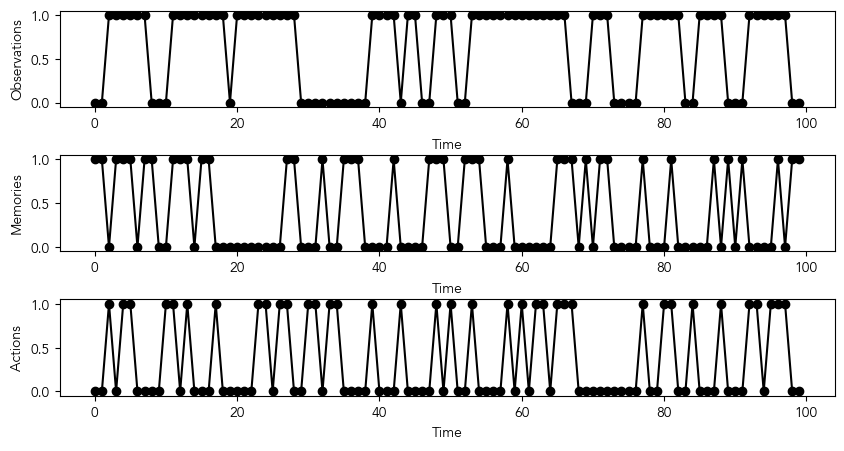

In [100]:
idx_trj = 0
trj = trajectories_inferred[idx_trj]
fig, ax = FSC_inferred.plot_trajectory(trj, Time)

# $M = 4$, $A = 2$, $Y = 3$, random - harder example

# Observations

In [185]:
NStepsObs = 100
NTraj = 500
Y = 3
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 2*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 1)
observations.shape

(500, 100)

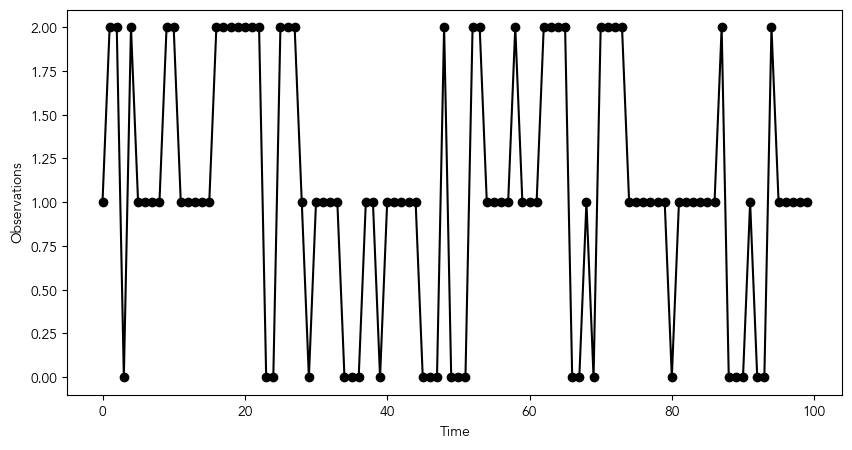

In [186]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(observations[0], 'o', label='Trajectory 0', color='black')
plt.plot(observations[0], color='black', label='Trajectory 0')
ax.set_xlabel('Time')
ax.set_ylabel('Observations')

plt.show()

In [187]:
M = 4
A = 2

np.random.seed(42)

Theta = np.random.randn(Y, M, M, A)

Psi = np.random.randn(M)

rho_sort = np.argsort(np.exp(Psi)/np.sum(np.exp(Psi)))
Psi = Psi[rho_sort]

FSC = FSC_DiscreteObs(Theta, Psi, verbose = True)

Initializing FSC with 4 memory states, 2 actions, and 3 observations.


In [188]:
FSC.load_observations(observations)

In [189]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

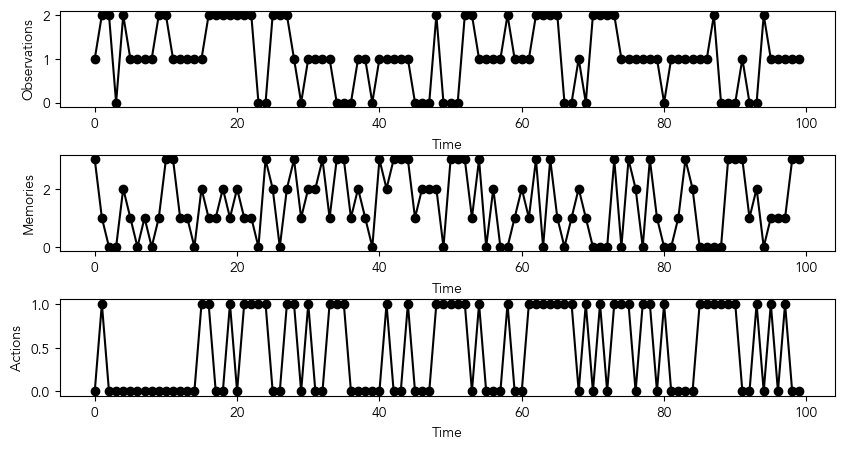

In [190]:
idx_trj = 0
trj = trajectories[idx_trj]
fig, ax = FSC.plot_trajectory(trj, Time)

In [193]:
nLL = 0

for trj in trajectories:
    nLL += FSC.evaluate_nloglikelihood(trj)

nLL/len(trajectories)

67.74490740583441

### Inference

In [196]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123456789)
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(71.7855, device='mps:0', grad_fn=<SubBackward0>)

In [197]:
tloss, vloss = FSC_tofit.optimize(NEpochs = 20, NBatch = 50, lr = 0.05, gamma = 0.99)

Training with 400 trajectories and validating with 100 trajectories.
Epoch 1 - Training loss: 68.44435119628906, Validation loss: 68.07417514801026 - Learning rate: 0.05
Epoch 2 - Training loss: 68.15465515136718, Validation loss: 67.9432640838623 - Learning rate: 0.0495
Epoch 3 - Training loss: 68.0042529296875, Validation loss: 67.90803398132324 - Learning rate: 0.049005
Epoch 4 - Training loss: 67.92445251464844, Validation loss: 67.82447891235351 - Learning rate: 0.04851495
Epoch 5 - Training loss: 67.90300598144532, Validation loss: 67.82918159484863 - Learning rate: 0.0480298005
Epoch 6 - Training loss: 67.88655212402344, Validation loss: 67.81404655456544 - Learning rate: 0.047549502495
Epoch 7 - Training loss: 67.88866455078124, Validation loss: 67.85436935424805 - Learning rate: 0.04707400747005
Epoch 8 - Training loss: 67.84752746582032, Validation loss: 67.79969833374024 - Learning rate: 0.0466032673953495
Epoch 9 - Training loss: 67.84474548339844, Validation loss: 67.81813

### Comparison

In [200]:
FSC_inferred = FSC_DiscreteObs(FSC_tofit.theta.detach().cpu().double().numpy(),
                               FSC_tofit.psi.detach().cpu().double().numpy(), verbose = True)

rho_sort = np.argsort(FSC_inferred.rho)

psi_sorted = FSC_inferred.psi[rho_sort]
theta_sorted = np.zeros_like(FSC_inferred.theta)

for idx_y, y in enumerate(FSC_inferred.ObsSpace):
    for idx_m1, m1 in enumerate(FSC_inferred.MemSpace):
        for idx_m2, m2 in enumerate(FSC_inferred.MemSpace):
            for idx_a, a in enumerate(FSC_inferred.ActSpace):
                theta_sorted[idx_y, idx_m1, idx_m2, idx_a] = FSC_inferred.theta[idx_y, rho_sort[idx_m1], rho_sort[idx_m2], idx_a]

FSC_inferred.load_theta(theta_sorted)
FSC_inferred.load_psi(psi_sorted)

Initializing FSC with 4 memory states, 2 actions, and 3 observations.


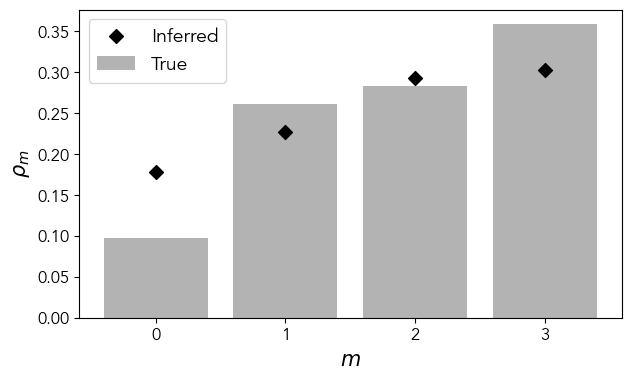

In [207]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(np.arange(M), FSC_inferred.rho, color = "dimgray", alpha = 0.5, label = "True")
ax.scatter(np.arange(M), FSC.rho, color = "black", marker = "D", s = 50, label = "Inferred")

ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xticks(np.arange(M))

plt.legend(fontsize = 14)

plt.show()

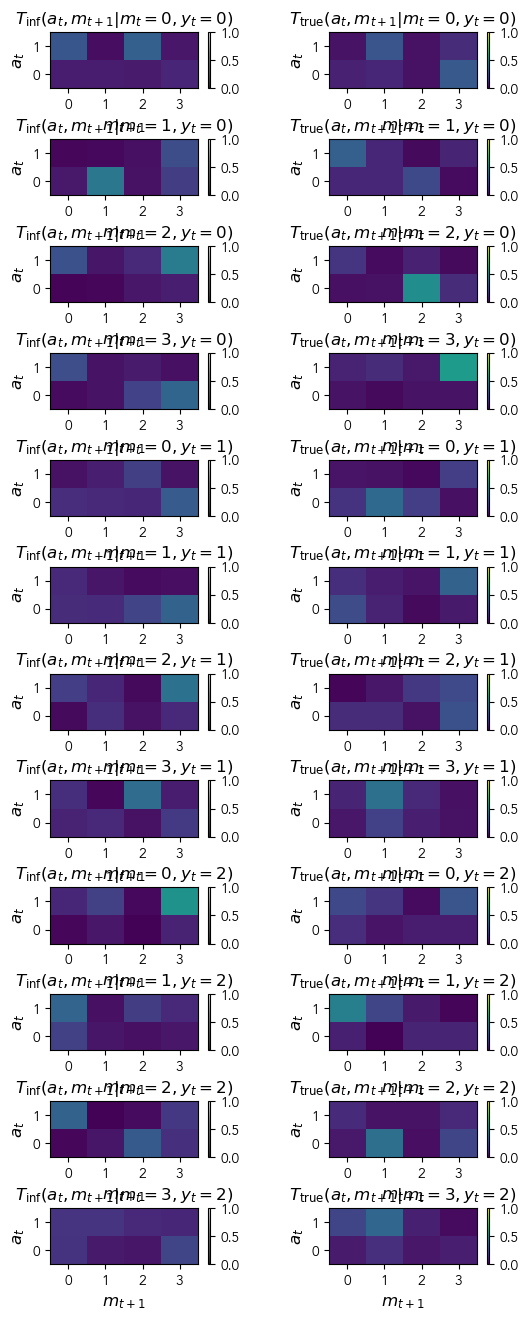

In [202]:
fig, axs = plt.subplots(Y*M, 2, figsize=(6,16))
plt.subplots_adjust(hspace = 0.9, wspace=0.5)
for a in axs.flatten():
    a.set_xticks(FSC.MemSpace)
    a.set_yticks(FSC.ActSpace)
    a.set_xlabel("$m_{t+1}$", fontsize = 12)
    a.set_ylabel("$a_t$", fontsize = 12)

c = 0
for idx_y, y in enumerate(FSC_inferred.ObsSpace):
    for idx_m, m in enumerate(FSC_inferred.MemSpace):
        im_inf = axs[c, 0].pcolormesh(FSC_inferred.MemSpace, FSC_inferred.ActSpace, FSC_inferred.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)
        im_true = axs[c, 1].pcolormesh(FSC.MemSpace, FSC.ActSpace, FSC.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)

        axs[c, 0].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")
        axs[c, 1].set_title(f"$T_\\mathrm{{true}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")

        cbar_inf = fig.colorbar(im_inf, ax=axs[c, 0])
        cbar_true = fig.colorbar(im_true, ax=axs[c, 1])

        c += 1

plt.show()

In [203]:
FSC_inferred.load_observations(observations)

In [204]:
trajectories_inferred = FSC_inferred.generate_trajectories(NSteps)

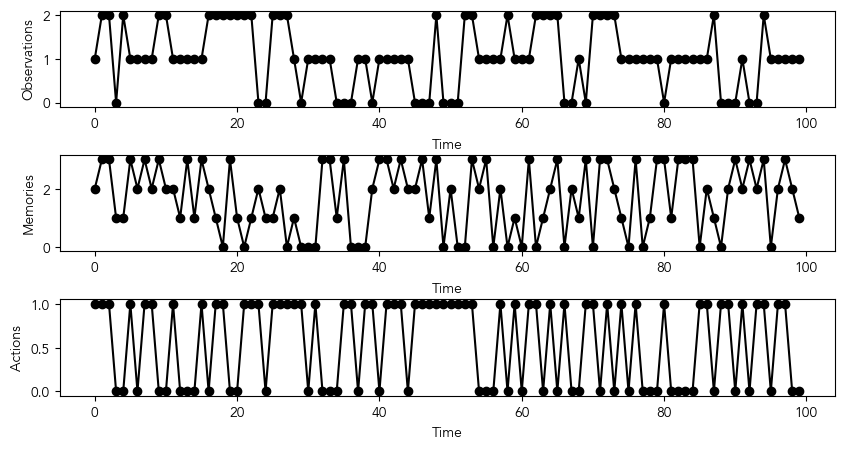

In [205]:
idx_trj = 0
trj = trajectories_inferred[idx_trj]
fig, ax = FSC_inferred.plot_trajectory(trj, Time)

# $M = 2$, $A = 2$, $Y = 3$ with structured transition matrix

In [208]:
NStepsObs = 100
NTraj = 100
Y = 3
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 5*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 42)
observations.shape

(100, 100)

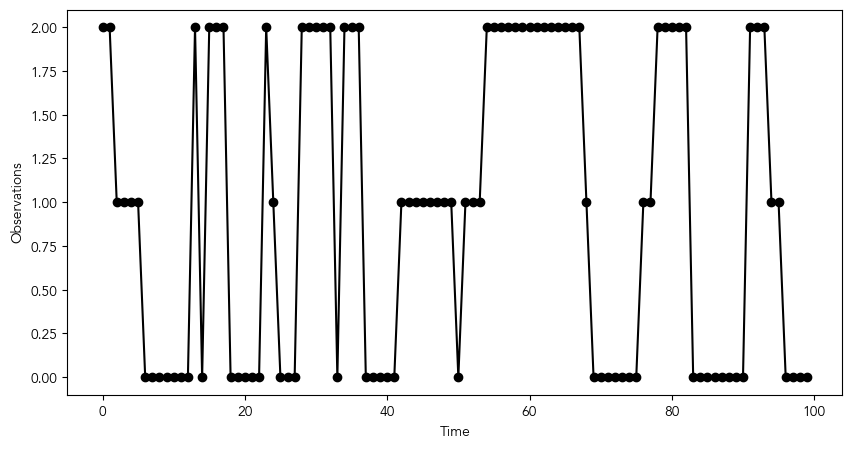

In [209]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(observations[0], 'o', label='Trajectory 0', color='black')
plt.plot(observations[0], color='black', label='Trajectory 0')
ax.set_xlabel('Time')
ax.set_ylabel('Observations')

plt.show()

In [281]:
M = 2
A = 2

ThetaFollowSwitchFollow = np.zeros((Y, M, M, A))

ThetaFollowSwitchFollow[0] = np.array([[[1, 0.1], [0.1, 0.1]],
                                      [[1.1, 0.1], [0.1, 0.1]]])

ThetaFollowSwitchFollow[2] = np.array([[[0.1, 0.1], [0.1, 1]],
                                      [[0.1,0.1], [0.1, 1.2]]])

ThetaFollowSwitchFollow[1] = np.array([[[0.5, 0.6], [1.3, 5]],
                                       [[1.3, 1], [0.6, 0.1]]])

Psi = np.array([1., 1.5])

FSC = FSC_DiscreteObs(ThetaFollowSwitchFollow, Psi, verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 3 observations.


In [282]:
FSC.rho

array([0.37754067, 0.62245933])

In [283]:
FSC.load_observations(observations)

In [284]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

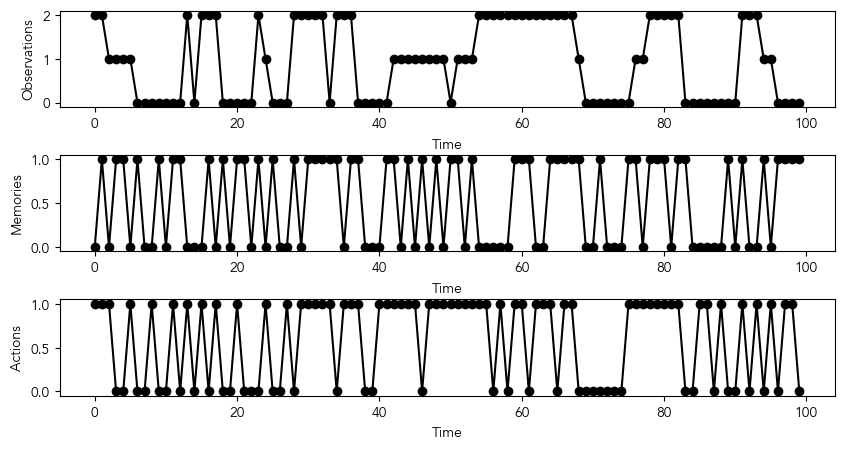

In [285]:
idx_trj = 0
trj = trajectories[idx_trj]
fig, ax = FSC.plot_trajectory(trj, Time)

In [286]:
FSC.evaluate_nloglikelihood(trajectories[0])

61.195372118725295

### Inference

In [287]:
M = 2
A = 2
Y = 3

In [288]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123456789)
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(71.4980, device='mps:0', grad_fn=<SubBackward0>)

In [289]:
tloss, vloss = FSC_tofit.optimize(NEpochs = 5, NBatch = 20, lr = 0.1, gamma = 0.9)

Training with 80 trajectories and validating with 20 trajectories.
Epoch 1 - Training loss: 67.91270141601564, Validation loss: 64.87014446258544 - Learning rate: 0.1
Epoch 2 - Training loss: 64.8389175415039, Validation loss: 64.1518419265747 - Learning rate: 0.09000000000000001
Epoch 3 - Training loss: 64.87043914794921, Validation loss: 64.7178991317749 - Learning rate: 0.08100000000000002
Epoch 4 - Training loss: 64.96722717285155, Validation loss: 64.58265018463135 - Learning rate: 0.07290000000000002
Epoch 5 - Training loss: 64.70567321777344, Validation loss: 64.17860927581788 - Learning rate: 0.06561000000000002


### Comparison

In [290]:
FSC_inferred = FSC_DiscreteObs(FSC_tofit.theta.detach().cpu().double().numpy(),
                               FSC_tofit.psi.detach().cpu().double().numpy(), verbose = True)

rho_sort = [1,0]

psi_sorted = FSC_inferred.psi[rho_sort]
theta_sorted = np.zeros_like(FSC_inferred.theta)

for idx_y, y in enumerate(FSC_inferred.ObsSpace):
    for idx_m1, m1 in enumerate(FSC_inferred.MemSpace):
        for idx_m2, m2 in enumerate(FSC_inferred.MemSpace):
            for idx_a, a in enumerate(FSC_inferred.ActSpace):
                theta_sorted[idx_y, idx_m1, idx_m2, idx_a] = FSC_inferred.theta[idx_y, rho_sort[idx_m1], rho_sort[idx_m2], idx_a]

FSC_inferred.load_theta(theta_sorted)
FSC_inferred.load_psi(psi_sorted)

Initializing FSC with 2 memory states, 2 actions, and 3 observations.


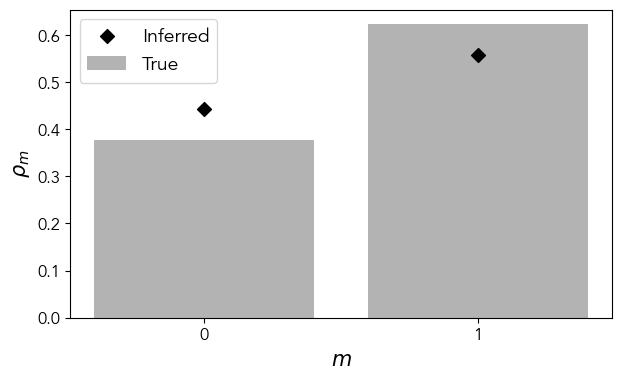

In [291]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(np.arange(M), FSC.rho, color = "dimgray", alpha = 0.5, label = "True")
ax.scatter(np.arange(M), FSC_inferred.rho, color = "black", marker = "D", s = 50, label = "Inferred")

ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xticks(np.arange(M))

plt.legend(fontsize = 14)

plt.show()

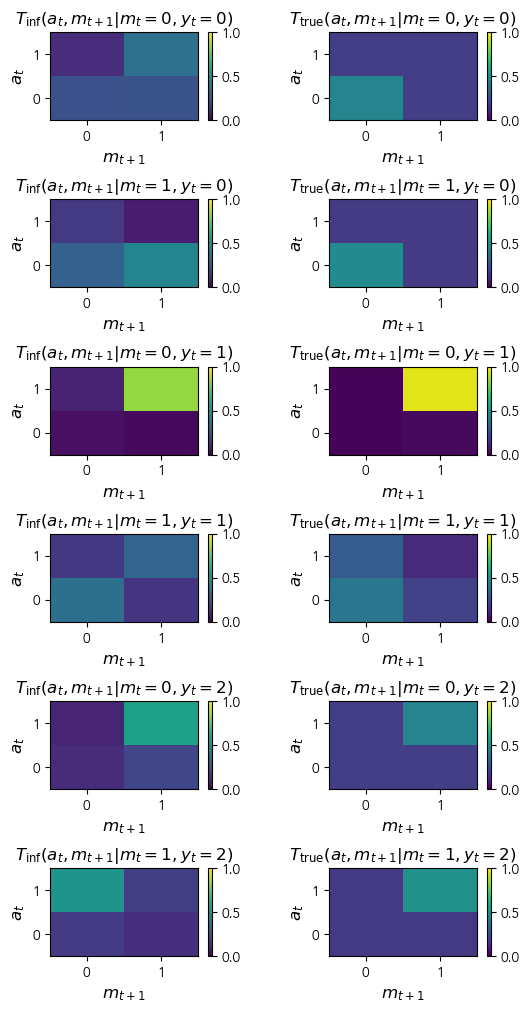

In [292]:
fig, axs = plt.subplots(Y*M, 2, figsize=(6,12))
plt.subplots_adjust(hspace = 0.9, wspace=0.5)
for a in axs.flatten():
    a.set_xticks(FSC.MemSpace)
    a.set_yticks(FSC.ActSpace)
    a.set_xlabel("$m_{t+1}$", fontsize = 12)
    a.set_ylabel("$a_t$", fontsize = 12)

c = 0
for idx_y, y in enumerate(FSC_inferred.ObsSpace):
    for idx_m, m in enumerate(FSC_inferred.MemSpace):
        im_inf = axs[c, 0].pcolormesh(FSC_inferred.MemSpace, FSC_inferred.ActSpace, FSC_inferred.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)
        im_true = axs[c, 1].pcolormesh(FSC.MemSpace, FSC.ActSpace, FSC.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)

        axs[c, 0].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")
        axs[c, 1].set_title(f"$T_\\mathrm{{true}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")

        cbar_inf = fig.colorbar(im_inf, ax=axs[c, 0])
        cbar_true = fig.colorbar(im_true, ax=axs[c, 1])

        c += 1

plt.show()

In [293]:
FSC_inferred.load_observations(observations)

In [294]:
trajectories_inferred = FSC_inferred.generate_trajectories(NSteps)

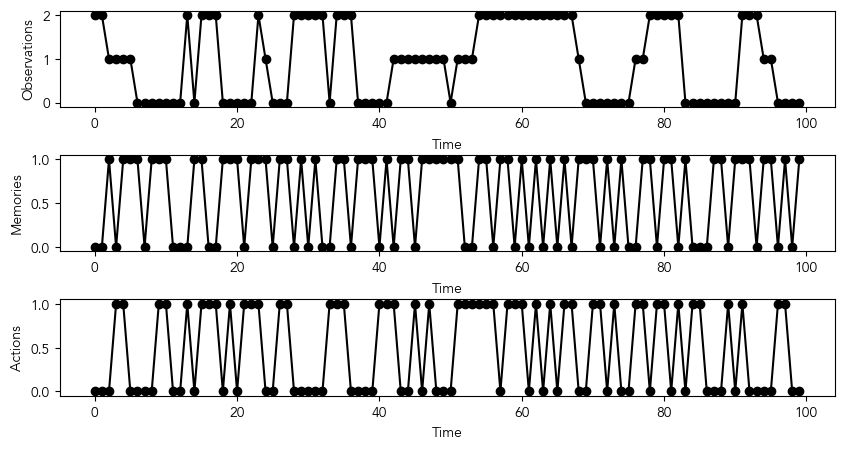

In [295]:
idx_trj = 0
trj = trajectories_inferred[idx_trj]
fig, ax = FSC_inferred.plot_trajectory(trj, Time)